In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_diabetes
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Фиксируем случайное состояние для воспроизводимости
RANDOM_STATE = 13
np.random.seed(RANDOM_STATE)

# 1. Подготовка данных и базовые модели

## 1.1. Загрузка и первичный анализ данных

In [2]:
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names_iris = iris.feature_names
target_names_iris = iris.target_names

print(f"Количество объектов: {X_iris.shape[0]}")
print(f"Количество признаков: {X_iris.shape[1]}")
print(f"Признаки: {feature_names_iris}")
print(f"Классы: {target_names_iris}")
print(f"Размерность данных: {X_iris.shape}")
print(f"Баланс классов: {np.bincount(y_iris)}")

# Разделение на обучающую и тестовую выборки
X_iris_train, X_iris_test, y_iris_train, y_iris_test = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=RANDOM_STATE, stratify=y_iris
)
print(f"\nРазделение данных Iris:")
print(f"Обучающая выборка: {X_iris_train.shape[0]} объектов")
print(f"Тестовая выборка: {X_iris_test.shape[0]} объектов")

Количество объектов: 150
Количество признаков: 4
Признаки: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Классы: ['setosa' 'versicolor' 'virginica']
Размерность данных: (150, 4)
Баланс классов: [50 50 50]

Разделение данных Iris:
Обучающая выборка: 105 объектов
Тестовая выборка: 45 объектов


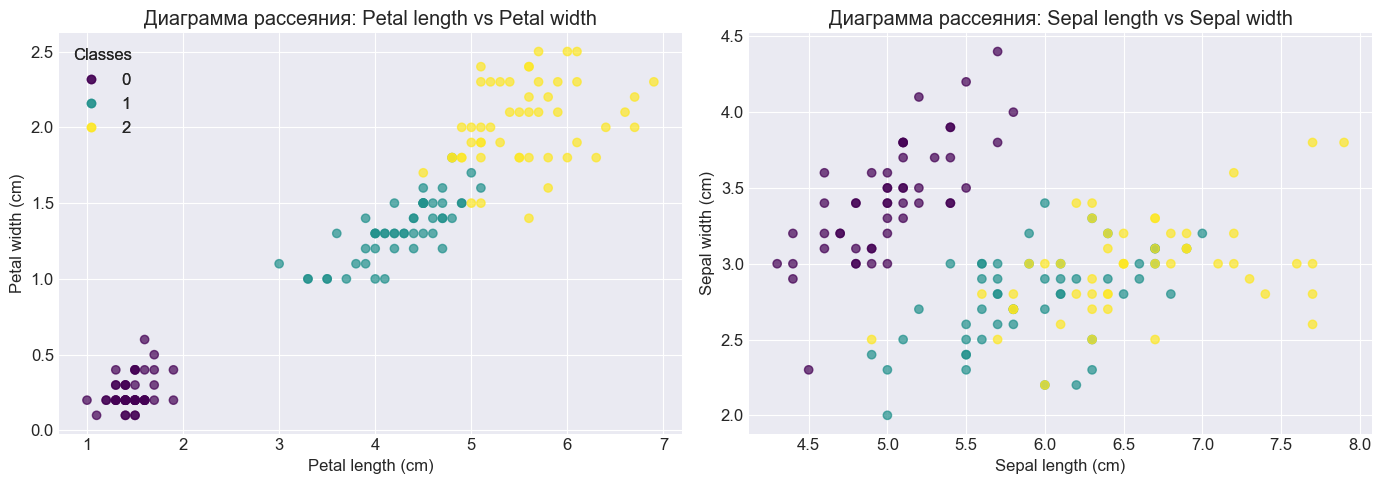

In [3]:
# Визуализация данных Iris
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Диаграмма рассеяния petal length vs petal width
scatter = axes[0].scatter(X_iris[:, 2], X_iris[:, 3], c=y_iris, cmap='viridis', alpha=0.7)
axes[0].set_xlabel('Petal length (cm)')
axes[0].set_ylabel('Petal width (cm)')
axes[0].set_title('Диаграмма рассеяния: Petal length vs Petal width')
legend1 = axes[0].legend(*scatter.legend_elements(), title="Classes")
axes[0].add_artist(legend1)

# Диаграмма рассеяния sepal length vs sepal width
scatter = axes[1].scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris, cmap='viridis', alpha=0.7)
axes[1].set_xlabel('Sepal length (cm)')
axes[1].set_ylabel('Sepal width (cm)')
axes[1].set_title('Диаграмма рассеяния: Sepal length vs Sepal width')

plt.tight_layout()
plt.show()

### Промежуточные выводы

По графикам видно, что классы хорошо разделимы, но только между 1 и 2 классом имеется небольшое наложение друг на друга, что делает разделение несколько труднее. Так что можно сделать вывод, что классы не являются полностью линейно разделимы. 

In [4]:
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target
feature_names_diabetes = diabetes.feature_names

print(f"Количество объектов: {X_diabetes.shape[0]}")
print(f"Количество признаков: {X_diabetes.shape[1]}")
print(f"Признаки: {feature_names_diabetes}")
print(f"Размерность данных: {X_diabetes.shape}")
print(f"\nСтатистика по целевой переменной:")
print(f"Минимум: {y_diabetes.min():.2f}")
print(f"Максимум: {y_diabetes.max():.2f}")
print(f"Среднее: {y_diabetes.mean():.2f}")
print(f"Стандартное отклонение: {y_diabetes.std():.2f}")

# Разделение на обучающую и тестовую выборки
X_diabetes_train, X_diabetes_test, y_diabetes_train, y_diabetes_test = train_test_split(
    X_diabetes, y_diabetes, test_size=0.3, random_state=RANDOM_STATE
)
print(f"\nРазделение данных Diabetes:")
print(f"Обучающая выборка: {X_diabetes_train.shape[0]} объектов")
print(f"Тестовая выборка: {X_diabetes_test.shape[0]} объектов")

Количество объектов: 442
Количество признаков: 10
Признаки: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Размерность данных: (442, 10)

Статистика по целевой переменной:
Минимум: 25.00
Максимум: 346.00
Среднее: 152.13
Стандартное отклонение: 77.01

Разделение данных Diabetes:
Обучающая выборка: 309 объектов
Тестовая выборка: 133 объектов


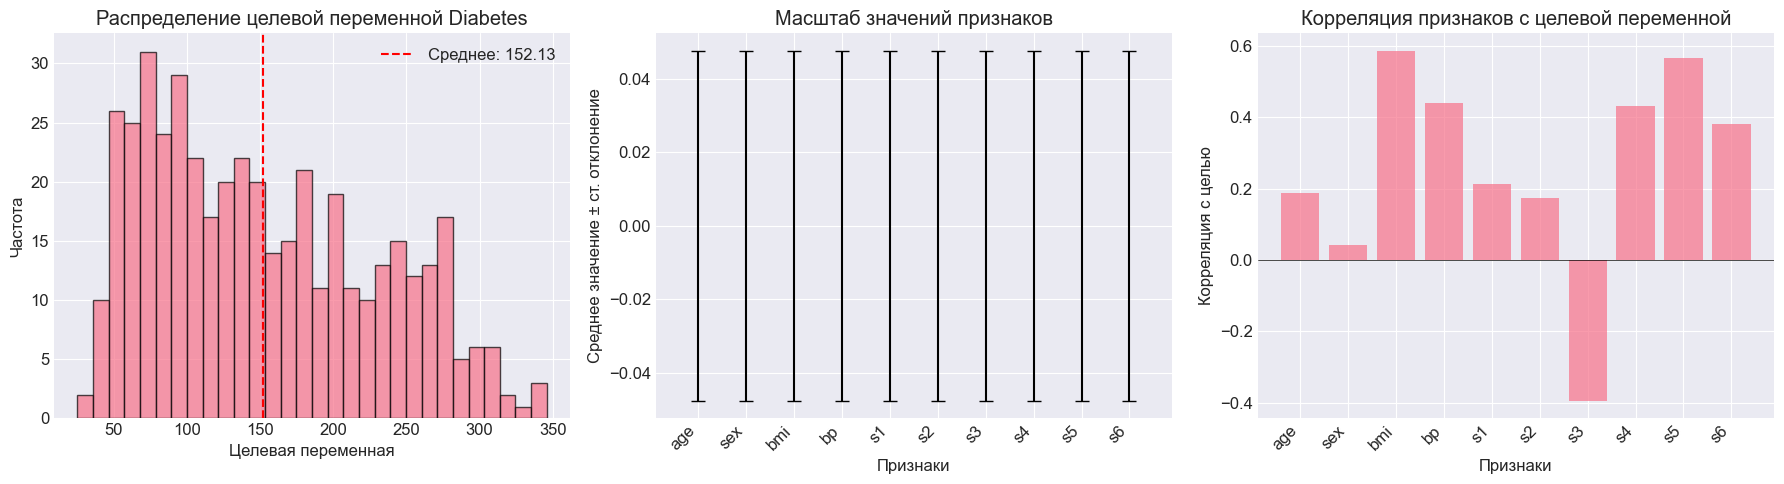

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Распределение целевой переменной
axes[0].hist(y_diabetes, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Целевая переменная')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение целевой переменной Diabetes')
axes[0].axvline(y_diabetes.mean(), color='red', linestyle='--', label=f'Среднее: {y_diabetes.mean():.2f}')
axes[0].legend()

# Масштаб признаков
feature_means = X_diabetes.mean(axis=0)
feature_stds = X_diabetes.std(axis=0)
x_pos = np.arange(len(feature_names_diabetes))
axes[1].bar(x_pos, feature_means, yerr=feature_stds, capsize=5, alpha=0.7)
axes[1].set_xlabel('Признаки')
axes[1].set_ylabel('Среднее значение ± ст. отклонение')
axes[1].set_title('Масштаб значений признаков')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(feature_names_diabetes, rotation=45, ha='right')

# Корреляция признаков с целевой переменной
correlations = [np.corrcoef(X_diabetes[:, i], y_diabetes)[0, 1] for i in range(X_diabetes.shape[1])]
axes[2].bar(x_pos, correlations, alpha=0.7)
axes[2].set_xlabel('Признаки')
axes[2].set_ylabel('Корреляция с целью')
axes[2].set_title('Корреляция признаков с целевой переменной')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(feature_names_diabetes, rotation=45, ha='right')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

### Промежуточные выводы

- Признаки из датасета диабета уже масштабированы (0 - среднее, 0.05 - дисперсия)
- Признаки bmi и s5 имеют заметную корреляцию с целевой переменной
- Линейная модель может быть недостаточной из-за возможных нелинейных зависимостей 

## 1.2. Базовые линейные модели (baseline)

In [6]:
# Iris
logreg = LogisticRegression(multi_class='ovr', max_iter=1000, random_state=RANDOM_STATE)
logreg.fit(X_iris_train, y_iris_train)

y_iris_train_pred = logreg.predict(X_iris_train)
y_iris_test_pred = logreg.predict(X_iris_test)

train_acc = accuracy_score(y_iris_train, y_iris_train_pred)
test_acc = accuracy_score(y_iris_test, y_iris_test_pred)

print(f"Точность на обучающей выборке: {train_acc:.4f}")
print(f"Точность на тестовой выборке: {test_acc:.4f}")
print(f"Разница: {abs(train_acc - test_acc):.4f}")

# Матрица ошибок
cm = confusion_matrix(y_iris_test, y_iris_test_pred)
print("\nМатрица ошибок на тестовой выборке:")
print(cm)

Точность на обучающей выборке: 0.9429
Точность на тестовой выборке: 0.9111
Разница: 0.0317

Матрица ошибок на тестовой выборке:
[[15  0  0]
 [ 0 11  4]
 [ 0  0 15]]


### Промежуточные выводы

Логистическая регрессия показывает хорошую точность на обучающей и тестовой выборках. Разница точностей показывает, что переобучение отсутствует.

In [7]:
# Diabets
linreg = LinearRegression()
linreg.fit(X_diabetes_train, y_diabetes_train)

y_diabetes_train_pred = linreg.predict(X_diabetes_train)
y_diabetes_test_pred = linreg.predict(X_diabetes_test)

train_mse = mean_squared_error(y_diabetes_train, y_diabetes_train_pred)
test_mse = mean_squared_error(y_diabetes_test, y_diabetes_test_pred)
train_r2 = r2_score(y_diabetes_train, y_diabetes_train_pred)
test_r2 = r2_score(y_diabetes_test, y_diabetes_test_pred)

print(f"MSE на обучающей выборке: {train_mse:.2f}")
print(f"MSE на тестовой выборке: {test_mse:.2f}")
print(f"R² на обучающей выборке: {train_r2:.4f}")
print(f"R² на тестовой выборке: {test_r2:.4f}")
print(f"Разница в R²: {abs(train_r2 - test_r2):.4f}")

# Коэффициенты модели
coefficients = pd.DataFrame({
    'Признак': feature_names_diabetes,
    'Коэффициент': linreg.coef_,
    'Абс. значение': np.abs(linreg.coef_)
}).sort_values('Абс. значение', ascending=False)

print(coefficients.head())

MSE на обучающей выборке: 2843.25
MSE на тестовой выборке: 3001.13
R² на обучающей выборке: 0.5412
R² на тестовой выборке: 0.4342
Разница в R²: 0.1071
  Признак  Коэффициент  Абс. значение
8      s5   728.766204     728.766204
4      s1  -635.554532     635.554532
2     bmi   560.559561     560.559561
3      bp   377.135329     377.135329
5      s2   273.415397     273.415397


### Промежуточные выводы

Линейная регрессия может объяснить только 43% дисперсии целевой переменной на тестовой выборке. Это говорит нам, что только линейной модели будет недостаточно для получения хороших результатов. Разница между R² говорит нам, что модель сильно не переобучилась, но уже начала.


# 2. Решающее дерево для классификации (Iris)

## Базовое дерево

          Модель  Точность train  Точность test  Разница
   Дерево (Gini)             1.0       0.977778 0.022222
Дерево (Entropy)             1.0       0.955556 0.044444

Дерево решений (критерий Gini)


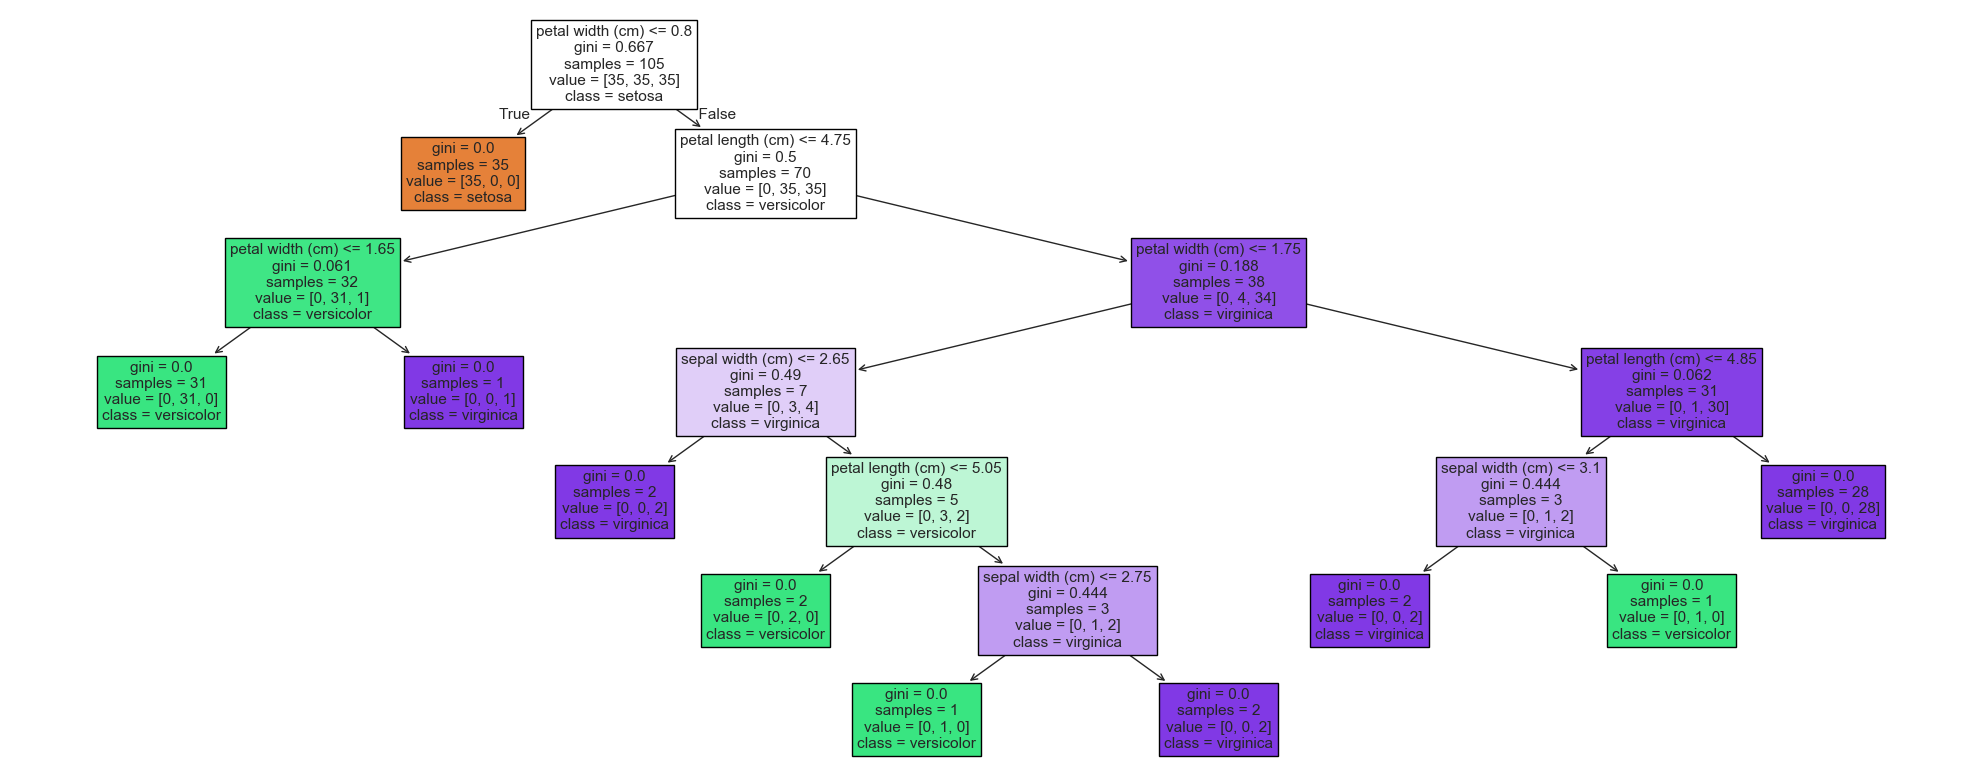

Дерево решений (критерий энтропии)


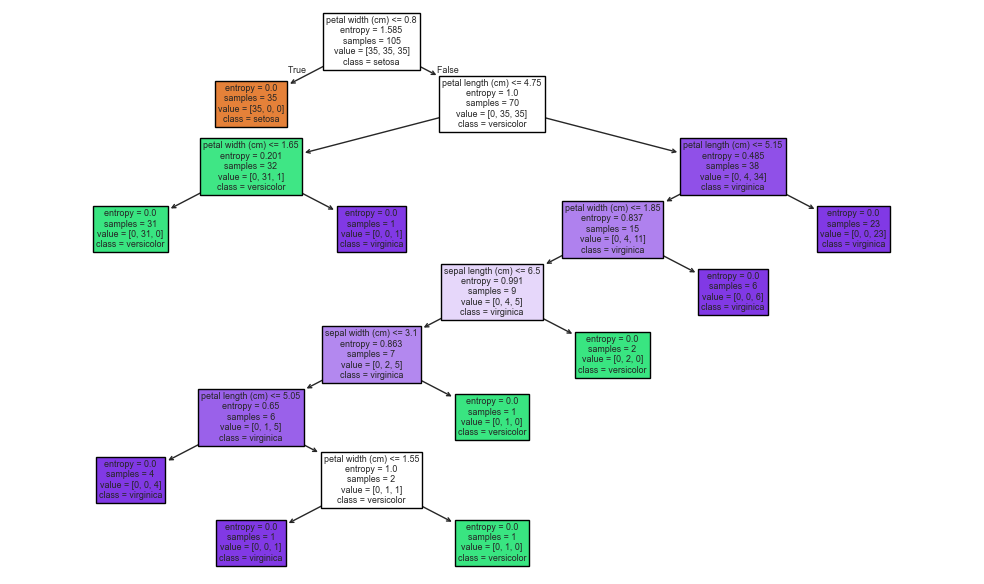

In [11]:
# Базовое дерево

# Дерево с критерием Gini
tree_gini = DecisionTreeClassifier(criterion='gini', random_state=RANDOM_STATE)
tree_gini.fit(X_iris_train, y_iris_train)

# Дерево с критерием энтропии
tree_entropy = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE)
tree_entropy.fit(X_iris_train, y_iris_train)

# Оценка качества
def evaluate_tree(model, X_train, y_train, X_test, y_test, model_name):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    return {
        'Модель': model_name,
        'Точность train': train_acc,
        'Точность test': test_acc,
        'Разница': abs(train_acc - test_acc)
    }

results = []
results.append(evaluate_tree(tree_gini, X_iris_train, y_iris_train, X_iris_test, y_iris_test, "Дерево (Gini)"))
results.append(evaluate_tree(tree_entropy, X_iris_train, y_iris_train, X_iris_test, y_iris_test, "Дерево (Entropy)"))

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Визуализация деревьев
fig, axes = plt.subplots(1, 1, figsize=(20, 8))
plot_tree(tree_gini, feature_names=feature_names_iris, class_names=target_names_iris, 
          filled=True)
print('\nДерево решений (критерий Gini)')

plt.tight_layout()
plt.show()

plot_tree(tree_entropy, feature_names=feature_names_iris, class_names=target_names_iris, 
          filled=True)
print('Дерево решений (критерий энтропии)')

plt.tight_layout()
plt.show()

### Промежуточные выводы

Оба дерева показывают одинаковую точность на тестовой выборке, что означает идеальную классификацию. Точность на тестовых выборках не равную 1 показывает, что модель хорошо классифицирует и не перееобучилась, притом Gini показывает немного лучше результаты.

##  Визуализация решений и оси-параллельные сплиты

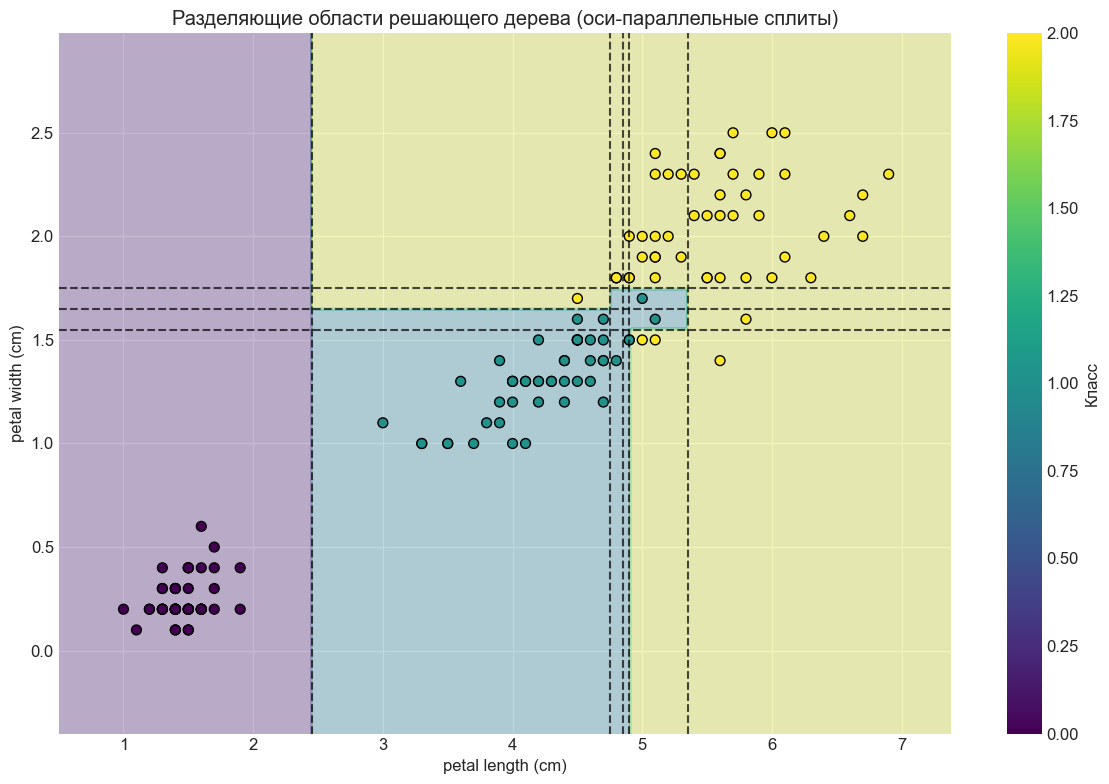

In [13]:
# Обучаем дерево только на двух признаках
selected_features = [2, 3]  # petal length, petal width
X_iris_2d = X_iris[:, selected_features]
feature_names_2d = [feature_names_iris[i] for i in selected_features]

X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(
    X_iris_2d, y_iris, test_size=0.3, random_state=RANDOM_STATE, stratify=y_iris
)

tree_2d = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_2d.fit(X_train_2d, y_train_2d)

# Создаем сетку для визуализации границ решений
x_min, x_max = X_iris_2d[:, 0].min() - 0.5, X_iris_2d[:, 0].max() + 0.5
y_min, y_max = X_iris_2d[:, 1].min() - 0.5, X_iris_2d[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Предсказания для каждой точки сетки
Z = tree_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Визуализация
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
scatter = plt.scatter(X_iris_2d[:, 0], X_iris_2d[:, 1], c=y_iris, 
                     cmap='viridis', edgecolor='black', s=50)
plt.xlabel(feature_names_2d[0])
plt.ylabel(feature_names_2d[1])
plt.title('Разделяющие области решающего дерева (оси-параллельные сплиты)')

# Добавляем линии, соответствующие сплитам дерева
def plot_decision_boundaries(tree, X, feature_names):
    n_classes = len(np.unique(y_iris))
    plot_colors = ['blue', 'red', 'green']
    
    # Получаем пороги разделения из дерева
    threshold = tree.tree_.threshold
    feature = tree.tree_.feature
    
    for i in range(tree.tree_.node_count):
        if tree.tree_.children_left[i] != tree.tree_.children_right[i]:  # не лист
            if feature[i] == 0:  # разделение по первому признаку
                plt.axvline(x=threshold[i], color='black', linestyle='--', alpha=0.7)
            elif feature[i] == 1:  # разделение по второму признаку
                plt.axhline(y=threshold[i], color='black', linestyle='--', alpha=0.7)

plot_decision_boundaries(tree_2d, X_iris_2d, feature_names_2d)
plt.colorbar(scatter, label='Класс')
plt.tight_layout()
plt.show()

### Промежуточные выводы

По графику видно, что границы являются оси-параллельными. График имеет ступеначтый вид по t, так как каждое разделение на подвыборки разделяет области по вертикали или по горизонтали и из этих областей формируются прямоугольные области.


## 2.3. Сравнение критериев: энтропия, Gini, доля ошибок

In [18]:

node_idx = 0
node_samples = tree_gini.tree_.n_node_samples[node_idx]
node_value = tree_gini.tree_.value[node_idx][0]
class_dist = node_value / node_samples

print(f"Распределение классов в корне: {class_dist}")

pk = class_dist
misclass = 1 - max(pk)
entropy = -np.sum(pk * np.log2(pk + 1e-10))
gini = 1 - np.sum(pk ** 2)

print(f"Доля ошибок: {misclass:.3f}")
print(f"Энтропия: {entropy:.3f}")
print(f"Индекс Джини: {gini:.3f}")

Распределение классов в корне: [0.0031746 0.0031746 0.0031746]
Доля ошибок: 0.997
Энтропия: 0.079
Индекс Джини: 1.000


### Промежуточные выводы

Все три критерия дают близкие значения при равномерном распределении, но по-разному реагируют на чистоту узлов.

## 2.4. Глубина дерева и переобучение

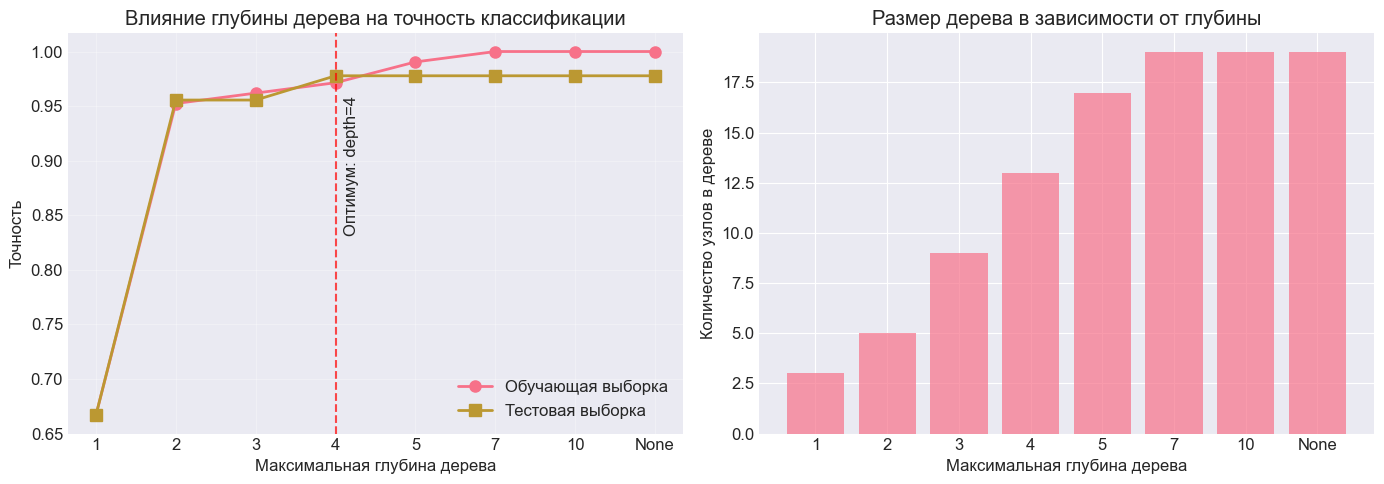

In [19]:
depths = [1, 2, 3, 4, 5, 7, 10, None]
train_scores = []
test_scores = []
tree_sizes = []

for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    tree.fit(X_iris_train, y_iris_train)
    
    train_pred = tree.predict(X_iris_train)
    test_pred = tree.predict(X_iris_test)
    
    train_scores.append(accuracy_score(y_iris_train, train_pred))
    test_scores.append(accuracy_score(y_iris_test, test_pred))
    tree_sizes.append(tree.tree_.node_count)

# Визуализация результатов
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График точности от глубины
depth_labels = [str(d) if d is not None else 'None' for d in depths]
x_pos = np.arange(len(depth_labels))

axes[0].plot(x_pos, train_scores, 'o-', label='Обучающая выборка', linewidth=2, markersize=8)
axes[0].plot(x_pos, test_scores, 's-', label='Тестовая выборка', linewidth=2, markersize=8)
axes[0].set_xlabel('Максимальная глубина дерева')
axes[0].set_ylabel('Точность')
axes[0].set_title('Влияние глубины дерева на точность классификации')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(depth_labels)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Добавляем аннотации для оптимальной глубины
optimal_depth_idx = np.argmax(test_scores)
axes[0].axvline(x=optimal_depth_idx, color='red', linestyle='--', alpha=0.7)
axes[0].text(optimal_depth_idx + 0.1, 0.5, f'Оптимум: depth={depth_labels[optimal_depth_idx]}', 
            rotation=90, transform=axes[0].get_xaxis_transform())

# График размера дерева от глубины
axes[1].bar(x_pos, tree_sizes, alpha=0.7)
axes[1].set_xlabel('Максимальная глубина дерева')
axes[1].set_ylabel('Количество узлов в дереве')
axes[1].set_title('Размер дерева в зависимости от глубины')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(depth_labels)

plt.tight_layout()
plt.show()

### Промежуточные выводы

При глубине больше 4 дерево начинает перееобучаться. Ограничения необходимы чтобы не запомнить всю выборку.

# 3. Решающее дерево для регрессии

##  3.1. Базовое дерево регрессии

In [22]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_diabetes_train, y_diabetes_train)

train_mse = mean_squared_error(y_diabetes_train, tree_reg.predict(X_diabetes_train))
test_mse = mean_squared_error(y_diabetes_test, tree_reg.predict(X_diabetes_test))

print("Дерево регрессии (без ограничений):")
print(f"MSE на обучении: {train_mse:.2f}")
print(f"MSE на тесте: {test_mse:.2f}")

Дерево регрессии (без ограничений):
MSE на обучении: 0.00
MSE на тесте: 5721.61


### Промежуточные выводы

MSE на обучении равное 0 показывает, что мы получили сильное перееобучение.

##  3.2. Глубина и MSE

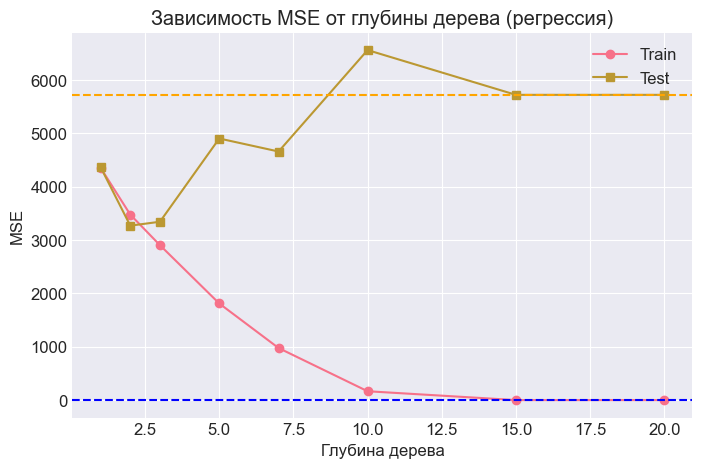

In [23]:

depths = [1, 2, 3, 5, 7, 10, 15, 20, None]
train_mses = []
test_mses = []

for depth in depths:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_diabetes_train, y_diabetes_train)
    train_mses.append(mean_squared_error(y_diabetes_train, tree.predict(X_diabetes_train)))
    test_mses.append(mean_squared_error(y_diabetes_test, tree.predict(X_diabetes_test)))

plt.figure(figsize=(8, 5))
plt.plot(depths[:-1], train_mses[:-1], label='Train', marker='o')
plt.plot(depths[:-1], test_mses[:-1], label='Test', marker='s')
plt.axhline(train_mses[-1], linestyle='--', color='blue')
plt.axhline(test_mses[-1], linestyle='--', color='orange')
plt.xlabel('Глубина дерева')
plt.ylabel('MSE')
plt.legend()
plt.title('Зависимость MSE от глубины дерева (регрессия)')
plt.show()

### Промежуточные выводы 

При слишком большой глубине дерева, модель начинает запоминать весь шум из выборки. Оптимальная глубина дерева примерно 7.

# 4. Ансамбли: бэггинг и Random Forest

## 4.1. Бэггинг деревьев (идея эксперимента)
- Из общей выборки берем объект столько раз, сколько у нас всего объектов в датасете. Один и тот же объект может попасть в подвыборку много раз. Обучаем дерево на таких выборках и получаем, что при каждом новом обучении модель будет ошибаться немного по-разному, но данные все берутся из общего датасета, поэтому мы можем уменьшить общее число ошибок для всего датасета. Деревья чувствительны к данным, так как небольшое изменение в них может координально изменить само построение дерева, а за счет этого результаты будут стабилизироваться.

- Каждое дерево обучается на своей подвыборке, в момент выбора признака для разбиения смотрит не на все признаки, а лишь только на их подмножество.

## 4.2. Random Forest для классификации

In [25]:

rf_clf = RandomForestClassifier(n_estimators=20, oob_score=True, random_state=RANDOM_STATE)
rf_clf.fit(X_iris_train, y_iris_train)

print(f"Точность одиночного дерева (без ограничений): {tree_gini.score(X_iris_test, y_iris_test):.3f}")
print(f"Точность Random Forest на тесте: {rf_clf.score(X_iris_test, y_iris_test):.3f}")
print(f"OOB-точность Random Forest: {rf_clf.oob_score_:.3f}")
     



Точность одиночного дерева (без ограничений): 0.978
Точность Random Forest на тесте: 0.978
OOB-точность Random Forest: 0.924


### Промежуточные выводы

- OOB-точность близка к тестовой
- OOB-оценка удобна, так как использует всю выборку, не требует разбиения.

## 4.3. Число деревьев и важности признаков

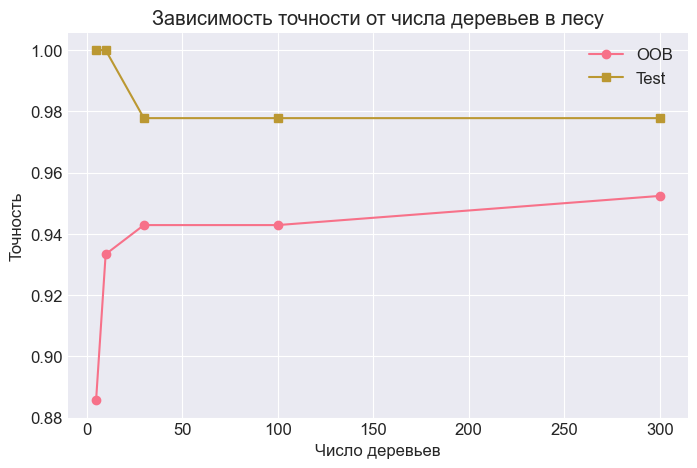

In [26]:
n_trees = [5, 10, 30, 100, 300]
oob_scores = []
test_scores = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    rf.fit(X_iris_train, y_iris_train)
    oob_scores.append(rf.oob_score_)
    test_scores.append(rf.score(X_iris_test, y_iris_test))

plt.figure(figsize=(8, 5))
plt.plot(n_trees, oob_scores, label='OOB', marker='o')
plt.plot(n_trees, test_scores, label='Test', marker='s')
plt.xlabel('Число деревьев')
plt.ylabel('Точность')
plt.legend()
plt.title('Зависимость точности от числа деревьев в лесу')
plt.show()

### Промежуточные выводы

при числе n_estimators примерно равном 30 качество стабилизируется. При увеличении числа деревьев качество не изменяется, так как каждое новое дерево добавляет все меньше новой информации.

### Важность признаков

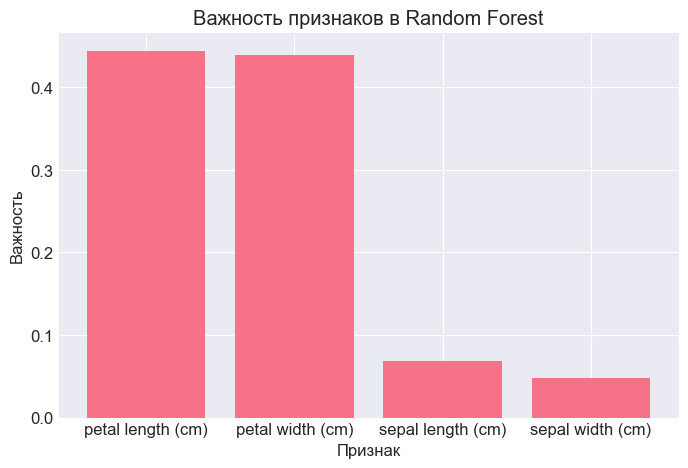

In [27]:
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(X_iris.shape[1]), importances[indices])
plt.xticks(range(X_iris.shape[1]), [feature_names_iris[i] for i in indices])
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.title('Важность признаков в Random Forest')
plt.show()

### Выводы

Наиболее важные признаки - petal length и petal width.

##  4.4. Random Forest для регрессии (мини-эксперимент)



In [28]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
rf_reg.fit(X_diabetes_train, y_diabetes_train)

train_mse_rf = mean_squared_error(y_diabetes_train, rf_reg.predict(X_diabetes_train))
test_mse_rf = mean_squared_error(y_diabetes_test, rf_reg.predict(X_diabetes_test))

print("Одиночное дерево регрессии (без ограничений):")
print(f"  MSE тест: {test_mse:.2f}")
print("Random Forest (100 деревьев):")
print(f"  MSE тест: {test_mse_rf:.2f}")
     


Одиночное дерево регрессии (без ограничений):
  MSE тест: 5721.61
Random Forest (100 деревьев):
  MSE тест: 2890.59


### Выводы

Random Forest значительно улучшает качество предсказаний по сравнению с одиночным деревом.

# 5. Дополнительные вопросы

1) Pre-pruning - останавливает рост дерева до того, как оно полностью разделит обучающие данные. Post-pruning - озволяет дереву вырасти полностью, а затем удаляет части, которые дают малое улучшение качества. Большенство библиотек использует pre-pruning, так как это менее ресурсозатратно. Random forest часто может обходится без pruning, так как усреднение предсказаний сглаживает шумы.

2) Деревья не требуют нормировки, так как разбиения основаны на сравнении значений с порогом, а также модель ищет оптимальные значения порогов. Хорошо работают с категориальными признаками, так как деревья хорошо бьют признаки на группы.

3) Одиночное дерево легко интерпритиремо, но склонно к переобучению. Random Forest - устойчивее к переобучению, лучше обобщает, но менее интерпретируемо.

4) Деревья или леса: оси-параллельные границы, хорошо работают с категориальными данными. SVM строит сложные нелинейные границы, требует нормировки. Выбор: SVM — для малых высокомерных данных, Random Forest — для табличных данных с категориями.


# Итоговые выводы

Решающие деревья:
- Сильно переобучаются без ограничений глубины.
- Критерии (Gini, энтропия) ведут себя схоже, но энтропия более чувствительна к чистым узлам.
- Оптимальная глубина находится через валидацию.

Ансамбли (Random Forest):
- Существенно улучшают обобщающую способность.
- OBB-оценка позволяет валидировать без отложенной выборки.
- Важности признаков помогают в интерпретации.

Практические советы:
- Всегда ограничивайте глубину деревьев (pre-pruning).
- Для табличных данных с категориями начинайте с Random Forest.
- Используйте OBB-оценку для быстрой проверки качества леса.

